In [1]:
#Following the tutorial from https://github.com/python-engineer/tensorflow-course/blob/master/08_09_Star_Wars_Project.ipynb

import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
BASE_DIR = 'lego/star-wars-images/'
names = ["YODA", "LUKE SKYWALKER", "R2-D2", "MACE WINDU", "GENERAL GRIEVOUS"]

tf.random.set_seed(1)

In [3]:
# Reorganize the folder structure:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [4]:
# Moce the image files
orig_folders = ["0001/", "0002/", "0003/", "0004/", "0005/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5)
    n_valid = int((number_of_images*0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

FileNotFoundError: [Errno 2] No such file or directory: 'lego/star-wars-images/0001/'

In [5]:
# Generate batches of tensor image data with
# optional real-time data augmentation.

# preprocessing_function
# rescale=1./255 -> [0,1]
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)#normalizing the data

##For data augmentation
#   rotation_range=20,
#   horizontal_flip=True,
#   width_shift_range=0.2, height_shift_range=0.2,
#   shear_range=0.2, zoom_range=0.2)

valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    'lego/star-wars-images/train',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=True, #This sould ve True
    color_mode="rgb",#we have rgb images 
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'lego/star-wars-images/val',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False, # This does not matter that much
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'lego/star-wars-images/test',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False, #This must be false
    color_mode="rgb",
    classes=names
)



Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [6]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])
test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[3. 4. 4. 3.]
(4, 256, 256, 3)
[0. 0. 1. 1.]


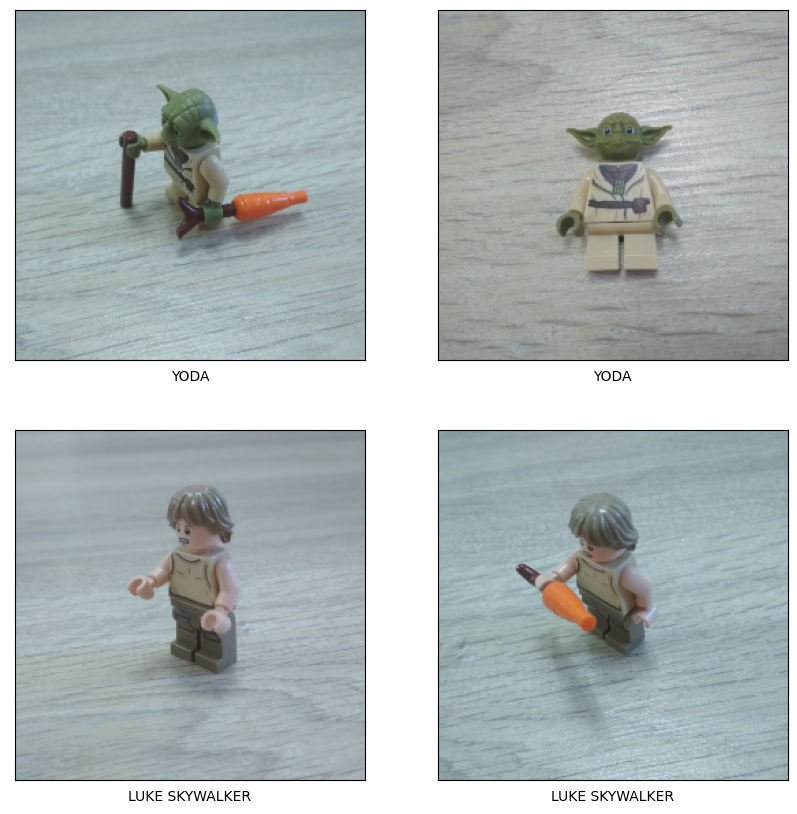

In [7]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

show(test_batch)



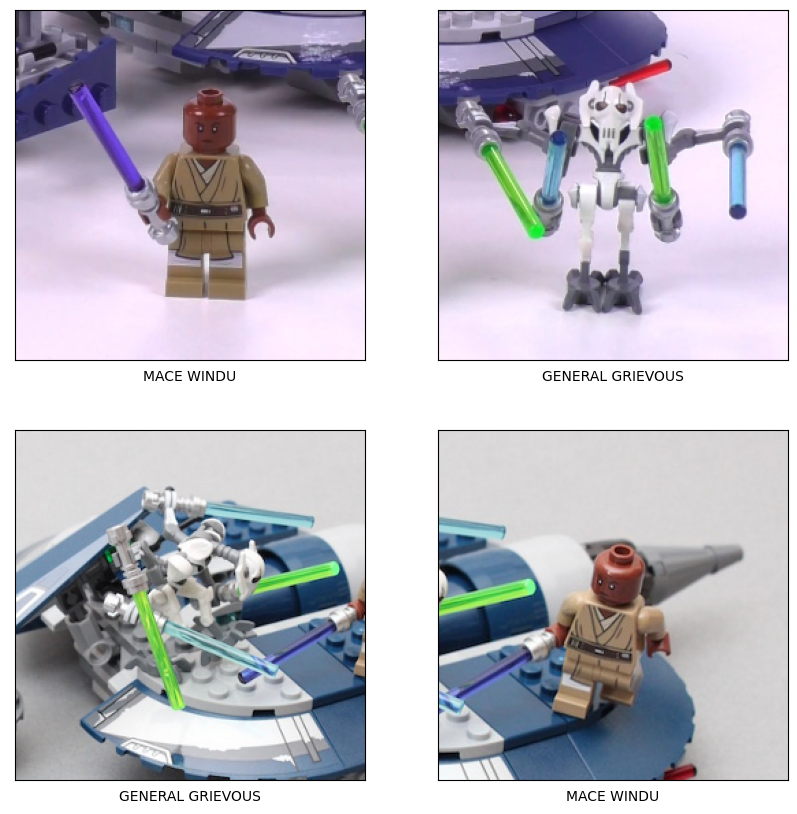

In [8]:
show(train_batch)

In [9]:
# Now we set up our convolutional model 

model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(256, 256,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
print(model.summary())

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                             

2022-10-13 14:01:19.846854: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-13 14:01:19.846966: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [11]:
# training
epochs = 30

# callbacks: a function applied after each training epoc (e.g. to add checkpoints) 
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", # to monitor the validation loss, i.e, 
                        #if it does not improve for the next X epcos, then it do an early stoping
    patience=5,
    verbose=2
)

history = model.fit(train_batches, validation_data=val_batches,
                    callbacks=[early_stopping],
                      epochs=epochs, verbose=2)

Epoch 1/30


2022-10-13 14:01:24.367039: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-13 14:01:24.565231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 - 1s - loss: 11.9152 - accuracy: 0.1622 - val_loss: 2.0966 - val_accuracy: 0.1875 - 1s/epoch - 102ms/step
Epoch 2/30


2022-10-13 14:01:25.288704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 - 1s - loss: 1.5689 - accuracy: 0.2973 - val_loss: 1.6280 - val_accuracy: 0.2500 - 596ms/epoch - 60ms/step
Epoch 3/30
10/10 - 1s - loss: 1.3291 - accuracy: 0.4054 - val_loss: 1.4568 - val_accuracy: 0.3125 - 581ms/epoch - 58ms/step
Epoch 4/30
10/10 - 1s - loss: 0.9707 - accuracy: 0.7297 - val_loss: 1.3418 - val_accuracy: 0.3750 - 590ms/epoch - 59ms/step
Epoch 5/30
10/10 - 1s - loss: 0.5453 - accuracy: 0.8108 - val_loss: 1.4105 - val_accuracy: 0.3750 - 597ms/epoch - 60ms/step
Epoch 6/30
10/10 - 1s - loss: 0.2297 - accuracy: 0.9730 - val_loss: 1.3981 - val_accuracy: 0.5000 - 581ms/epoch - 58ms/step
Epoch 7/30
10/10 - 1s - loss: 0.1280 - accuracy: 0.9730 - val_loss: 1.2713 - val_accuracy: 0.5000 - 599ms/epoch - 60ms/step
Epoch 8/30
10/10 - 1s - loss: 0.0298 - accuracy: 1.0000 - val_loss: 1.3064 - val_accuracy: 0.5000 - 591ms/epoch - 59ms/step
Epoch 9/30
10/10 - 1s - loss: 0.1145 - accuracy: 0.9459 - val_loss: 1.4067 - val_accuracy: 0.5000 - 595ms/epoch - 59ms/step
Epoch 10/30
10/10 -

In [ ]:
model.save("lego_model.h5")

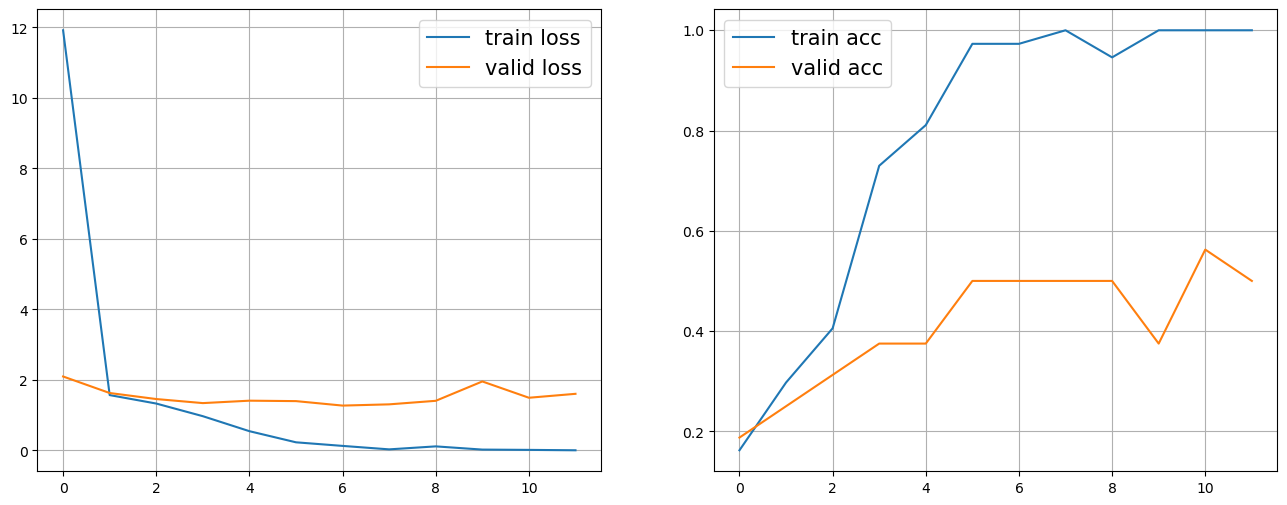

In [12]:
# plot loss and acc
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15)


In [13]:
# evaluate on test data
model.evaluate(test_batches, verbose=2)

3/3 - 0s - loss: 1.3957 - accuracy: 0.7000 - 108ms/epoch - 36ms/step


[1.3957451581954956, 0.699999988079071]

3/3 [==============================] - 0s 19ms/step


2022-10-13 14:02:25.860989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[0. 0. 1. 1.]
[0 2 1 1]


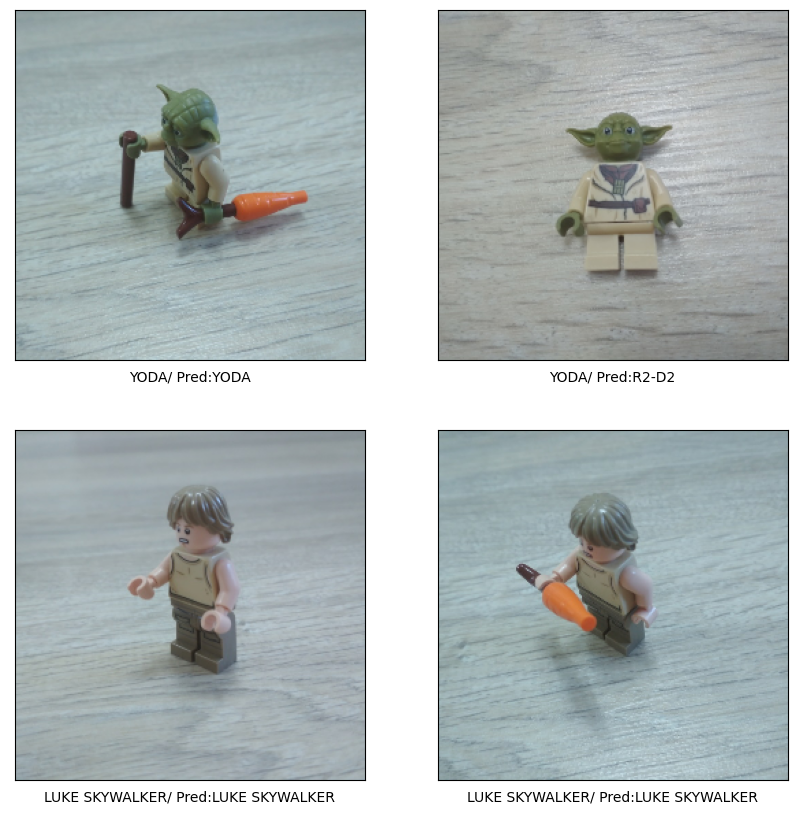

In [14]:
# make some predictions
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1]) #Predicted labels
print(labels[0:4]) #Real labels


show(test_batches[0], labels[0:4])